In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Lecture 11
### Neural Network with :

Changes for the Assignment:
- Tensorflow
- **Fuctional API**
- **FIFA Dataset**
- One hidden layer 
- **multi-class**
- ADAM
- Mini Batch
- ${Swish}$ Activation function

<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from collections.abc import Callable
from typing import Literal
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import tensorflow as tf 
%matplotlib inline

2023-11-28 11:59:01.804065: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# gpus = tf.config.list_physical_devices('GPU')

# try:
#     for g in gpus:
#         tf.config.experimental.set_memory_growth(g, True)
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print (len(gpus), 'Phusical GPUs', len(logical_gpus), 'Logical GPUs')
# except:
#     print ('invalid device')

In [4]:
###----------------
### Some parameters
###----------------

inpDir = '../../input'
outDir = '../output'
subDir = 'fifa_2019'
modelDir = '.../models'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 101 # number of epochs
ALPHA = 0.1 # learning rate
NUM_SAMPLES = 1280 # How many samples we want to generate 
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2
BATCH_SIZE = 32
TRAIN_SIZE = 14496 # fix size of train set sot that we have batches of same size
PATIENCE = 10

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'coolwarm' # plt.cm.Spectral

plt.rcParams.update(params)

## Helper Functions

In [5]:
###-----------------------------------
### Function to plot Decision boundary
###-----------------------------------

def fn_plot_decision_boundary(pred_func: Callable[[], np.float64], X_tr: np.ndarray, y_tr: np.ndarray, X_ts :  np.ndarray, y_ts:  np.ndarray,):
    '''
        Attrib:
           pred_func : function based on predict method of the classifier
           X_tr : train feature matrix
           y_tr : train labels
           X_ts : test feature matrix
           y_ts : test labels
       Return:
           None
    '''
    
    # Set min and max values and give it some padding
    xMin, xMax = X_tr[:, 0].min() - .05, X_tr[:, 0].max() + .05
    yMin, yMax = X_tr[:, 1].min() - .05, X_tr[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.01
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    ax = fig.add_axes(111)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP) #, alpha = 0.8
    
    # Plotting scatter for train data
    ax.scatter(X_tr[:, 0], X_tr[:, 1], 
               c=np.argmax(y_tr, axis = 1), # y_tr has two columns 
               s=30, edgecolor='k', cmap=plt.cm.coolwarm)
    
    
    # Plotting scatter for test data
    ax.scatter(X_ts[:, 0], X_ts[:, 1], 
               c=np.argmax(y_ts, axis = 1), # y_tr has two columns ,
                                  s=150, marker = '*',edgecolor='k', cmap=plt.cm.inferno )


## Generate Data Set
FIFA 2019 Dataset

In [6]:
data_df = pd.read_csv('fifa_2019.csv')
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [7]:
for col in data_df.columns:
    print (f'{col} : {data_df[col].unique()}')

Unnamed: 0 : [    0     1     2 ... 18204 18205 18206]
ID : [158023  20801 190871 ... 241638 246268 246269]
Name : ['L. Messi' 'Cristiano Ronaldo' 'Neymar Jr' ... 'B. Worman'
 'D. Walker-Rice' 'G. Nugent']
Age : [31 33 26 27 32 25 29 28 24 30 19 40 22 23 34 35 36 37 21 18 20 39 41 17
 38 45 42 16 44]
Photo : ['https://cdn.sofifa.org/players/4/19/158023.png'
 'https://cdn.sofifa.org/players/4/19/20801.png'
 'https://cdn.sofifa.org/players/4/19/190871.png' ...
 'https://cdn.sofifa.org/players/4/19/241638.png'
 'https://cdn.sofifa.org/players/4/19/246268.png'
 'https://cdn.sofifa.org/players/4/19/246269.png']
Nationality : ['Argentina' 'Portugal' 'Brazil' 'Spain' 'Belgium' 'Croatia' 'Uruguay'
 'Slovenia' 'Poland' 'Germany' 'France' 'England' 'Italy' 'Egypt'
 'Colombia' 'Denmark' 'Gabon' 'Wales' 'Senegal' 'Costa Rica' 'Slovakia'
 'Netherlands' 'Bosnia Herzegovina' 'Morocco' 'Serbia' 'Algeria' 'Austria'
 'Greece' 'Chile' 'Sweden' 'Korea Republic' 'Finland' 'Guinea'
 'Montenegro' 'Armenia' '

In [8]:
data_df.isnull().sum()

Unnamed: 0           0
ID                   0
Name                 0
Age                  0
Photo                0
                  ... 
GKHandling          48
GKKicking           48
GKPositioning       48
GKReflexes          48
Release Clause    1564
Length: 89, dtype: int64

In [9]:
data_df = data_df [data_df['Position'].notnull()]
data_df.shape

(18147, 89)

In [10]:
data_df.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

In [11]:
rel_columns = ['Position','Finishing',  'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes']

"""['Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', ,
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       , ,  'Release Clause']"""

"['Name', 'Age', 'Photo', 'Nationality', 'Flag',\n       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',\n       'Preferred Foot', 'International Reputation', 'Weak Foot',\n       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', ,\n       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',\n       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',\n       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',\n       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',\n       , ,  'Release Clause']"

In [12]:
data_df = data_df[rel_columns]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [13]:
data_df.isna().sum()

Position           0
Finishing          0
HeadingAccuracy    0
ShortPassing       0
Volleys            0
Dribbling          0
Curve              0
FKAccuracy         0
LongPassing        0
BallControl        0
Acceleration       0
SprintSpeed        0
Agility            0
Reactions          0
Balance            0
ShotPower          0
Jumping            0
Stamina            0
Strength           0
LongShots          0
Aggression         0
Interceptions      0
Positioning        0
Vision             0
Penalties          0
Composure          0
Marking            0
StandingTackle     0
SlidingTackle      0
GKDiving           0
GKHandling         0
GKKicking          0
GKPositioning      0
GKReflexes         0
dtype: int64

In [14]:
data_df.Position.unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB'], dtype=object)

In [15]:
goalkeeper = 'GK'

forward = [ 'ST', 'LW', 'RW', 'LF', 'RF', 'RS', 'LS', 'CF']
midfielders = ['CM', 'RCM', 'LCM', 'CDM', 'RDM', 'LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defence = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB',  'RB']

In [16]:
data_df.loc[data_df['Position'] == 'GK' ,          'Position'] = 0

data_df.loc[data_df['Position'].isin(defence) ,    'Position'] = 1

data_df.loc[data_df['Position'].isin(midfielders), 'Position'] = 2

data_df.loc[data_df['Position'].isin(forward) ,    'Position'] = 3

data_df['Position'] =pd.to_numeric(data_df['Position'], downcast='integer')

In [17]:
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [18]:
data_df['Position'].unique()

array([3, 0, 2, 1], dtype=int8)

In [19]:
labels = { 0 : 'Goal Keepers', 1: 'Defence', 2: 'Mid-fielders', 3: 'Forward'}

In [20]:
featuloss_df = data_df.drop('Position', axis = 1) # drop label col

label_df = data_df['Position'] # labels

featuloss_df.shape, label_df.shape

((18147, 33), (18147,))

In [21]:
#label_df = pd.get_dummies(label_df)
label_df.shape

(18147,)

In [22]:
label_df.head()

0    3
1    3
2    3
3    0
4    2
Name: Position, dtype: int8

In [23]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(featuloss_df, label_df, 
                                                    stratify=label_df,
                                                    train_size=TRAIN_SIZE, 
                                                    random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14496, 33) (14496,) (3651, 33) (3651,)


In [24]:
scaler = StandardScaler() # get the scaler

X_train = scaler.fit_transform(X_train) # train
X_test = scaler.transform(X_test) # test

y_train = y_train.to_numpy() # array
y_test = y_test.to_numpy() # convert to array

In [25]:
y_train

array([0, 2, 2, ..., 0, 0, 0], dtype=int8)

## Neural Network

Let's start with simple network. Our data has **two** features. Hence size of input layer will also be two. Lets code our output as two classes. The hidden layer could be of **any size**. One need to execute a handful of iterations to arrive at right size of hidden layer. For purpose of today's discussions, size of hidden layer is taken as shown below.
<img src='../../images/dnn_nb_s05_fig1.png' width = '500' alt = 'Session 5 Figure 1'/>

## Prepare Model:

In [26]:
knl_reg = tf.keras.regularizers.L2(l2 = 0.001)

dor1 = 0.05

'''model = tf.keras.Sequential([
    
    tf.keras.layers.Dense(18, #activation='swish',
                          kernel_regularizer = knl_reg ),
    
    tf.keras.layers.BatchNormalization(),
    
    #Put Activation Layer here
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Dropout(rate=dor1, seed=RANDOM_STATE),
    
    tf.keras.layers.Dense(4)

])'''

input_layer = tf.keras.Input(shape=(33,))

x = tf.keras.layers.Dense(18, activation='swish',
                          kernel_regularizer = knl_reg ) (input_layer)

x = tf.keras.layers.Dense(9, activation='swish',
                          kernel_regularizer = knl_reg ) (x)

output_layer = tf.keras.layers.Dense(4) (x)

model = tf.keras.Model(inputs= input_layer, outputs = output_layer)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33)]              0         
                                                                 
 dense (Dense)               (None, 18)                612       
                                                                 
 dense_1 (Dense)             (None, 9)                 171       
                                                                 
 dense_2 (Dense)             (None, 4)                 40        
                                                                 
Total params: 823
Trainable params: 823
Non-trainable params: 0
_________________________________________________________________


2023-11-28 11:59:06.682805: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [27]:
loss_function = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [28]:
X_train[:1].shape

(1, 33)

In [29]:
predict = model(X_train[:1])
predict

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-1.0018543 , -0.3022858 ,  0.20048031, -0.39462522]],
      dtype=float32)>

In [30]:
predict.numpy().sum()

-1.4982849

In [31]:
tf.nn.softmax(predict).numpy().sum()

1.0

In [32]:
model.compile(optimizer='adam', 
              loss=loss_function,
              metrics=['accuracy'])

In [92]:
history = model.fit(X_train, y_train, 
                    validation_data=[X_test, y_test],
                    epochs=EPOCHS,
                    verbose=2,
                    batch_size=BATCH_SIZE
                    )

Epoch 1/101
453/453 - 4s - loss: 0.6146 - accuracy: 0.7836 - val_loss: 0.4088 - val_accuracy: 0.8420 - 4s/epoch - 8ms/step
Epoch 2/101
453/453 - 2s - loss: 0.3698 - accuracy: 0.8647 - val_loss: 0.3585 - val_accuracy: 0.8622 - 2s/epoch - 5ms/step
Epoch 3/101
453/453 - 2s - loss: 0.3447 - accuracy: 0.8738 - val_loss: 0.3459 - val_accuracy: 0.8666 - 2s/epoch - 5ms/step
Epoch 4/101
453/453 - 2s - loss: 0.3353 - accuracy: 0.8758 - val_loss: 0.3402 - val_accuracy: 0.8636 - 2s/epoch - 5ms/step
Epoch 5/101
453/453 - 2s - loss: 0.3287 - accuracy: 0.8774 - val_loss: 0.3354 - val_accuracy: 0.8661 - 2s/epoch - 5ms/step
Epoch 6/101
453/453 - 3s - loss: 0.3239 - accuracy: 0.8783 - val_loss: 0.3329 - val_accuracy: 0.8696 - 3s/epoch - 6ms/step
Epoch 7/101
453/453 - 2s - loss: 0.3214 - accuracy: 0.8791 - val_loss: 0.3321 - val_accuracy: 0.8669 - 2s/epoch - 5ms/step
Epoch 8/101
453/453 - 2s - loss: 0.3175 - accuracy: 0.8824 - val_loss: 0.3256 - val_accuracy: 0.8694 - 2s/epoch - 5ms/step
Epoch 9/101
453/

In [93]:
loss_df = pd.DataFrame(history.history)

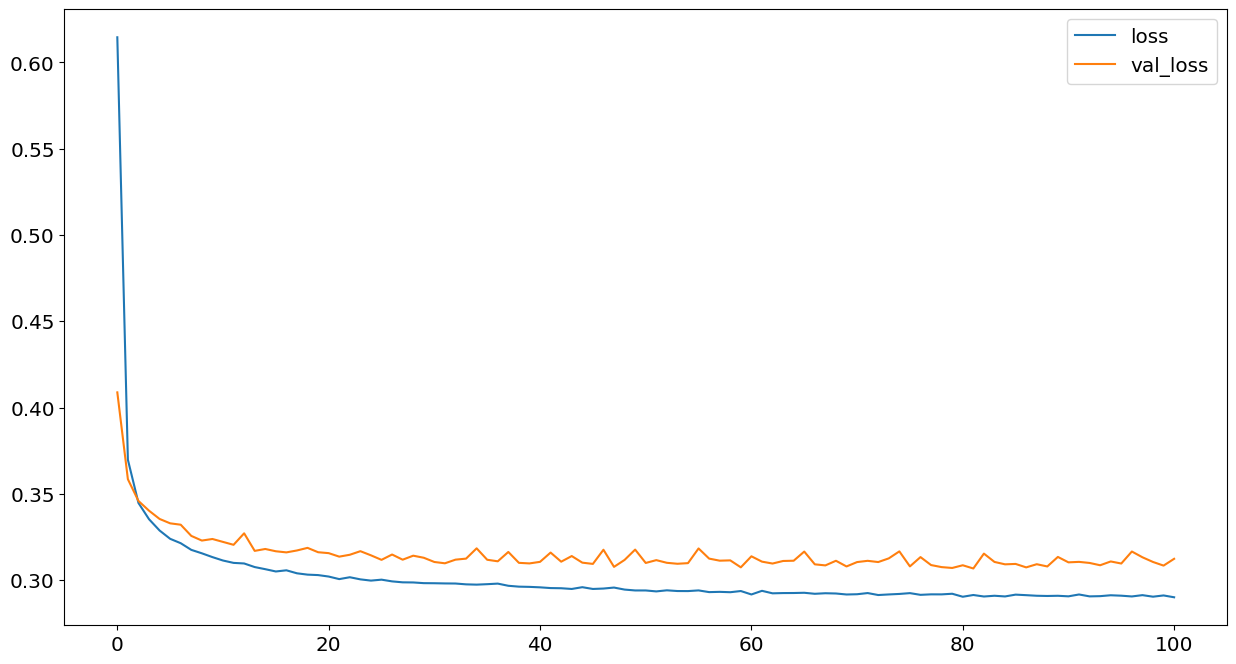

In [94]:
loss_df.plot(y = ['loss', 'val_loss']);

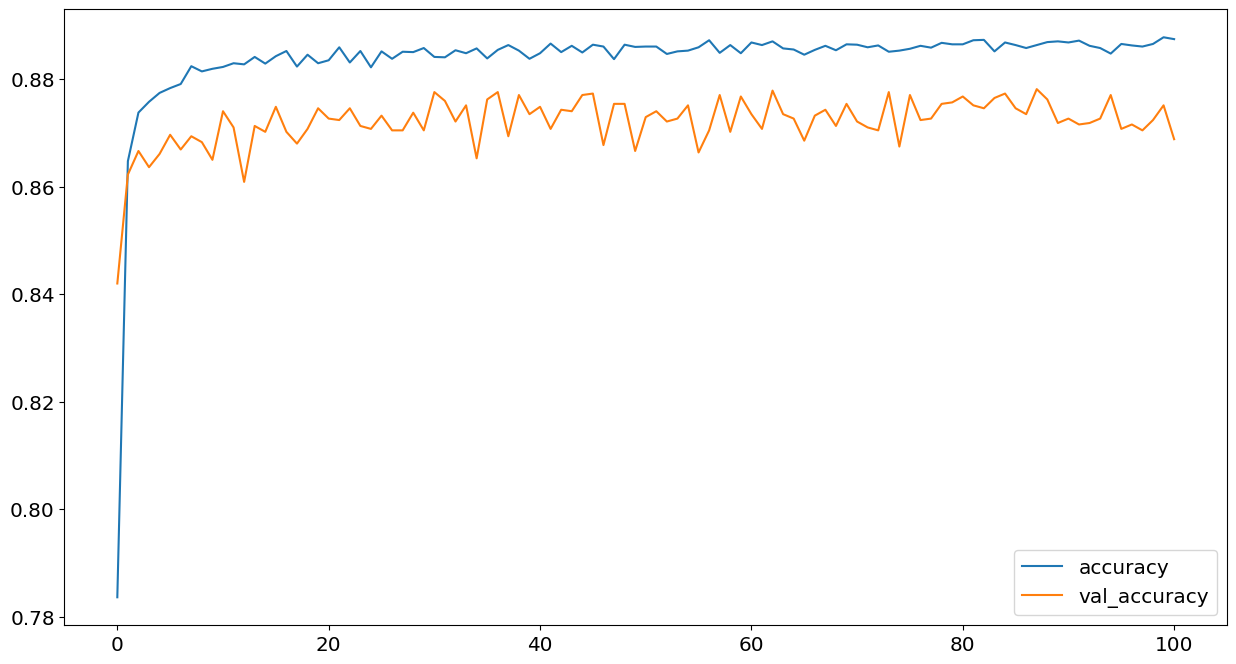

In [95]:
loss_df.plot(y = ['accuracy', 'val_accuracy']);

In [96]:
model.evaluate(X_train, y_train)

453/453 [==============================] - 2s 4ms/step - loss: 0.2891 - accuracy: 0.8856


[0.289074182510376, 0.8856236338615417]

In [97]:
model.evaluate(X_test, y_test)

115/115 [==============================] - 1s 4ms/step - loss: 0.3123 - accuracy: 0.8688


[0.31233468651771545, 0.868803083896637]

In [98]:
y_pred = model.predict(X_train)

453/453 [==============================] - 2s 3ms/step


In [99]:
accuracy_score (np.argmax(y_pred, axis = 1), y_train)

0.8856236203090507

In [100]:
y_pred = model.predict(X_test)
accuracy_score (np.argmax(y_pred, axis = 1), y_test)

115/115 [==============================] - 1s 4ms/step


0.8688030676526979

In [101]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 33)]              0         
                                                                 
 dense_6 (Dense)             (None, 18)                612       
                                                                 
 dense_7 (Dense)             (None, 9)                 171       
                                                                 
 dense_8 (Dense)             (None, 4)                 40        
                                                                 
Total params: 823
Trainable params: 823
Non-trainable params: 0
_________________________________________________________________


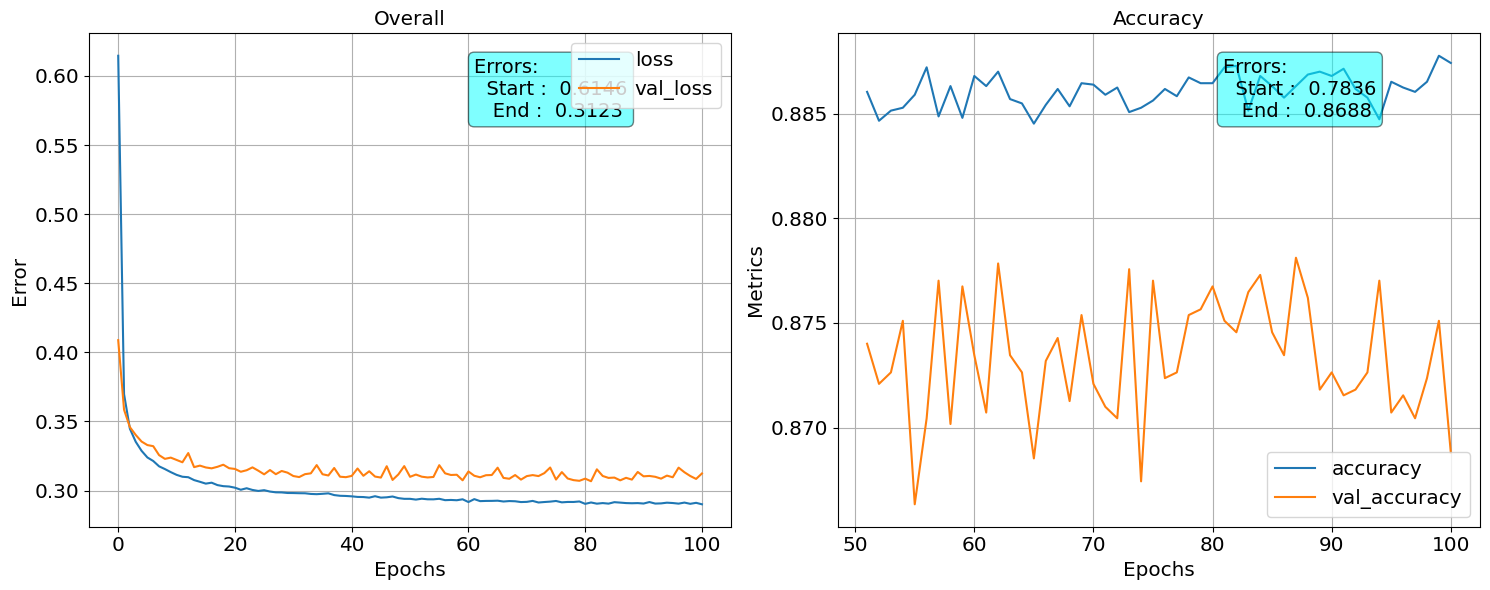

In [106]:
fig, axes = plt.subplots(1,2 , figsize = (15,6))

l_range = 50

ax = axes[0]
y1 = loss_df.columns[0]
y2 = loss_df.columns[2]

loss_df.plot( y = [y1, y2], ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss_df.iloc[0][y1],
                                                                loss_df.iloc[-1][y2]) #text to plot

# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='aqua', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Overall')
ax.grid();

ax = axes[1]
y1 = loss_df.columns[1]
y2 = loss_df.columns[3]
loss_df[-l_range:].plot( y = [y1, y2], ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss_df.iloc[0][y1],
                                                                loss_df.iloc[-1][y2]) #text to plot

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Metrics")
ax.set_title(y1.capitalize())
ax.grid();
plt.tight_layout()

In [107]:
loss_df[loss_df['val_loss'] == loss_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy,ephocs
81,0.291355,0.88721,0.306724,0.875103,81


In [33]:
# Chceckpoint
checkpointPath = os.path.join(modelDir, subDir)
checkpointPath

'.../models/fifa_2019'

In [35]:
model_check_point = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpointPath,
    save_weights_only = True,
    save_best_only = True,
    monitor = 'val_loss',
    verbose = 1
)

es_check_point = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    verbose=1,
    restore_best_weights=True,
    start_from_epoch=0,
)


In [36]:
history = model.fit(X_train, y_train, 
                    validation_data=[X_test, y_test],
                    epochs=EPOCHS,
                    verbose=2,
                    batch_size=BATCH_SIZE,
                    callbacks=[model_check_point, es_check_point ]
                    )

Epoch 1/101

Epoch 1: val_loss improved from inf to 0.48168, saving model to .../models/fifa_2019
453/453 - 4s - loss: 0.6886 - accuracy: 0.7766 - val_loss: 0.4817 - val_accuracy: 0.8332 - 4s/epoch - 9ms/step
Epoch 2/101

Epoch 2: val_loss improved from 0.48168 to 0.37744, saving model to .../models/fifa_2019
453/453 - 3s - loss: 0.4052 - accuracy: 0.8580 - val_loss: 0.3774 - val_accuracy: 0.8617 - 3s/epoch - 8ms/step
Epoch 3/101

Epoch 3: val_loss improved from 0.37744 to 0.35624, saving model to .../models/fifa_2019
453/453 - 2s - loss: 0.3540 - accuracy: 0.8700 - val_loss: 0.3562 - val_accuracy: 0.8669 - 2s/epoch - 5ms/step
Epoch 4/101

Epoch 4: val_loss improved from 0.35624 to 0.34669, saving model to .../models/fifa_2019
453/453 - 2s - loss: 0.3404 - accuracy: 0.8747 - val_loss: 0.3467 - val_accuracy: 0.8713 - 2s/epoch - 5ms/step
Epoch 5/101

Epoch 5: val_loss improved from 0.34669 to 0.33931, saving model to .../models/fifa_2019
453/453 - 2s - loss: 0.3331 - accuracy: 0.8765 - v

In [37]:
savePath = os.path.join(modelDir, subDir, 'vanila')
tf.keras.models.save_model(model, savePath)

INFO:tensorflow:Assets written to: .../models/fifa_2019/vanila/assets


INFO:tensorflow:Assets written to: .../models/fifa_2019/vanila/assets


In [39]:
del model

In [40]:
model.summary()

NameError: name 'model' is not defined

In [42]:
model1 = tf.keras.models.load_model(savePath)
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33)]              0         
                                                                 
 dense (Dense)               (None, 18)                612       
                                                                 
 dense_1 (Dense)             (None, 9)                 171       
                                                                 
 dense_2 (Dense)             (None, 4)                 40        
                                                                 
Total params: 823
Trainable params: 823
Non-trainable params: 0
_________________________________________________________________


In [43]:
input_layer = tf.keras.Input(shape=(33,))

x = tf.keras.layers.Dense(18, activation='swish',
                          kernel_regularizer = knl_reg ) (input_layer)

x = tf.keras.layers.Dense(9, activation='swish',
                          kernel_regularizer = knl_reg ) (x)

output_layer = tf.keras.layers.Dense(4) (x)

model = tf.keras.Model(inputs= input_layer, outputs = output_layer)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 33)]              0         
                                                                 
 dense_3 (Dense)             (None, 18)                612       
                                                                 
 dense_4 (Dense)             (None, 9)                 171       
                                                                 
 dense_5 (Dense)             (None, 4)                 40        
                                                                 
Total params: 823
Trainable params: 823
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.load_weights(checkpointPath)

In [45]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 33)]              0         
                                                                 
 dense_3 (Dense)             (None, 18)                612       
                                                                 
 dense_4 (Dense)             (None, 9)                 171       
                                                                 
 dense_5 (Dense)             (None, 4)                 40        
                                                                 
Total params: 823
Trainable params: 823
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.compile(optimizer='adam', 
              loss=loss_function,
              metrics=['accuracy'])

model.evaluate(X_test, y_test)

115/115 [==============================] - 1s 4ms/step - loss: 0.3032 - accuracy: 0.8751


[0.3031790852546692, 0.875102698802948]